<center><h1>  Hierarchical Spectral Clustering     </h1> </center>



The purpose of this notebook is to show the application of the convex HC algorithm to the analysis of mutliscale graph data. That is, we are given a graph with hierarchical structure, and the goal is to uncover the different levels of structure in the dataset. In particular, we aim here to show how our method can be utilized to extract the hierarchies at different levels.

The procedure to run the experiment is the follwoing:
 - __step 1:__ we generate a graph with nested hierarchical structure. We use here the square of the adjacency matrix $A^2 =A^TA$ as our SPsD representation of the similarities.
 - __step 2:__ we run the graph-based similarity algorithm to extract representations of the graph at different levels of regularizations $\lambda$ in order to get the regularization path $\pi(\lambda)$
 - __step 3:__ we run spectral clustering on each representation, determining the correct number of clusters with the elbow method. We compare the results to the ground truth labels by computing the homogeneity, accuracy and silhouette scores of each clustering.
 - __step 4:__ we compare our results with (a) spectral clustering on the original similarity matrix using the same number of clusters, (b) average linkage (c) ward clustering (d) robust hierarchical clustering ( the plots are simply displayed: the code was run separatedly using the Matlab implementation provided on the authors' webpage) (d) LIP HC (HC via spreading metrics).

# I. Generating the data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sc
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
import sys
sys.path.append('../')
from projections import*
from convex_hc_denoising import*
from convex_hc_ADMM import*
from utils import *
import networkx as nx
import pickle


In [3]:
import matplotlib.pyplot as plt

from shapes.shapes import *
from shapes.construct_graph import *
import sklearn as sk
import random
random.seed(2018)

G, labels = build_fractal_structure(3,
                                 ['nx.gnp_random_graph','nx.gnp_random_graph','nx.gnp_random_graph'],
                                 [[7,0.9],[7,0.9],[4,0.9]])
A = nx.adjacency_matrix(G)
K = A.T.dot(A)


number of connected components:  1


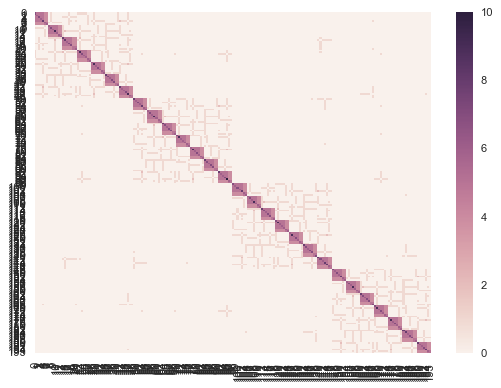

In [4]:
sb.heatmap(K.todense())

As we can see from the previous heatmap, this graph has 2 levels of community structure: there are 28 close-knit communities at the fine scale, which are themselves distributed among 4 main ones.

# II. Running the procedure

We here propose to use the parameter-free FISTA based version of the algorithm. We have selected 18 values for $\lambda$ (our choice was guided by a preliminary sweep through possible values of $\lambda$, to determine  which range induced the most variation in the behavior of $\pi(\lambda)$.)

In [7]:

K = A.T.dot(A)
Deg = np.diagflat(1.0/np.sqrt(np.diag(K.todense())))
K = sc.sparse.csc_matrix(Deg.dot(K.todense().dot(Deg)))

In [8]:
K.todense()

matrix([[ 1.        ,  0.77151675,  0.71428571, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.77151675,  1.        ,  0.77151675, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.71428571,  0.77151675,  1.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  1.        ,
          0.57735027,  0.63245553],
        [ 0.        ,  0.        ,  0.        , ...,  0.57735027,
          1.        ,  0.91287093],
        [ 0.        ,  0.        ,  0.        , ...,  0.63245553,
          0.91287093,  1.        ]])

In [55]:
"""
Code for the dual FISTA algorithm for hierarchical
convex clustering
"""
import copy
import math
import numpy as np
import scipy as sc
import time

from projections import *
from utils import *

TOL_PROJ = 1e-4
TOL_INC = 5
TOL = 1e-2
MAX_ITER_PROJ = 1e4
MAXITER_FISTA = 200
ALPHA = 0.5


def hcc_FISTA_denoise(K, B, pi_prev, lambd, alpha=ALPHA, maxiterFISTA=MAXITER_FISTA,
                      eta=1.0, tol=TOL, verbose=True, tol_projection=TOL_PROJ,
                      max_iter_projection=MAX_ITER_PROJ,
                      logger = None):
    ''' Hierarchical clustering algorithm based on FISTA (dual)
    Input: similarity matrix K assumed to be from a Mercer kernel (or at least PSD)
    Output: the regularized soft membership assignment matrix
    --------------------------------------------------------------------------
    
    INPUT:
    -----------------------------------------------------------
    K            :      the similarity matrix
    pi_prev      :      initialization value for pi (warm start)
    lambd        :      the level of regularization desired 
    alpha        :      parameter for the total variation mixed penalty
    maxiterFISTA :      max number of iterations for FISTA (updates in X)
    tol          :      tolerance level for the stopping criterion,
                        as a fraction of the number of nodes
    sparse       :      boolean: should the algorithm assume sparisty of K?
    verbose      :      boolean: allow printing of various statistics
                        and intermediary parameters

    OUTPUT:
    -----------------------------------------------------------
    X           :      the corresponding soft clustering assignment matrix
    t           :      the time that the procedure took
    delta_x     :      list of updates in x (for each iteration)
    delta_p     :      list of updates in p (for each iteration)
    delta_q     :      list of updates in q (for each iteration)
    dual        :      dual updates
    
    --------------------------------------------------------------------------
    '''
    # Initialization
    x_k, x_km1, y_k = pi_prev, pi_prev, pi_prev
    n_nodes, _ = pi_prev.shape
    if type(K) == np.matrixlib.defmatrix.matrix:
        mask = np.array(K).flatten().reshape([-1,]).nonzero()[0]
    else:
        indices = K.nonzero()
        mask = []
        for i in range(K.nnz):
            mask += [indices[0][i]*n_nodes+indices[1][i]]
        mask = np.array(mask)


    I = sc.sparse.eye(n_nodes)
    delta_k=sc.sparse.lil_matrix((n_nodes, n_nodes**2))
    for ii in range(n_nodes):
        ind =K[ii, :].nonzero()[1]
        delta_k[ii, ii * n_nodes + ind] = K[ii, ind]
        delta_k[ii, ii + ind * n_nodes] = -K[ii, ind]
        delta_k[ii, ii + ii * n_nodes] = 0.0
    delta_k = delta_k[:, mask]
    delta_k = delta_k.todense()

    lmax = np.linalg.norm(delta_k,'fro')**2
    #lmax = np.max(K.T.dot(K).diagonal())
    #gamma = 4 * max([alpha**2,(1-alpha)**2])*lmax * lambd**2
    gamma = 16 * max([alpha**2,(1-alpha)**2])*lmax * lambd**2
    if verbose: print("lmax",lmax, "gamma", gamma)
    I = sc.sparse.eye(n_nodes)
    update = (delta_k.T.dot(x_k.T)).T
    #print("update.max(())", update.max())

    q = np.zeros((n_nodes, len(mask)))
    p = project_unit_ball(update,
                         is_sparse=False)


    q[np.where(update != 0)]= project_unit_cube(update[np.where(update != 0)],
                                                is_sparse=False)



    index_rev = [jj*n_nodes + ii  for ii in range(n_nodes) for jj in range(n_nodes)]
    #print("init p", p.max(), q.max(), q.min())
    t_k, it = 1, 1
    converged = False
    
    t_k, it = 1, 1
    converged = False

    tic0 = time.time()
    delta_x = []
    delta_p = []
    delta_q = []
    dual = []
    it = 0
    eps_reg =1e-5

    p_old = copy.deepcopy(p)
    q_old = copy.deepcopy(q)
    r = copy.deepcopy(p)
    s = copy.deepcopy(q)
    inc = 0
    vpos = np.vectorize(lambda x: x if x>0 else 0)
    while not converged:
        belly = (alpha * r + (1-alpha) * s).dot(delta_k.T)
        proj = project_DS_symmetric(vpos(B-lambd * belly),  max_it=max_iter_projection, eps = tol_projection)
        x_k = proj
        L_x = proj.dot(delta_k)
        #print("update.max(())", L_x.max())

        update_p = p + 2.0 * alpha *lambd / gamma * L_x
        p = project_unit_ball(update_p,
                              is_sparse=False)

        update_q = q+ 2.0 * (1-alpha) / gamma * L_x
        inv_update_q = copy.deepcopy(update_q)
        inv_update_q[np.where(update_q!=0)] = 1.0/np.abs(update_q[np.where(inv_update_q!=0)])
        q =   np.multiply(inv_update_q, update_q)    

        if verbose: print("max q, p",q.max(), q.min(), p.max(), p.min())

        #### Check convergence
        delta_x.append(np.linalg.norm( x_k - x_km1, 'fro')/np.linalg.norm(x_km1,'fro'))
        delta_p.append(np.linalg.norm(p - p_old, 'fro'))
        delta_q.append(np.linalg.norm(q - q_old, 'fro'))
        
        if delta_x[-1] < TOL:
                inc += 1
        else:
                inc = 0

        converged = (math.sqrt((alpha**2 * np.linalg.norm(p-p_old,'fro')**2 
                                + (1 - alpha)**2 * np.linalg.norm(q-q_old,'fro')**2))
                     / np.max([0, math.sqrt((alpha**2 * np.linalg.norm(p_old,'fro')**2 
                                 + (1 - alpha)**2 * np.linalg.norm(q_old,'fro')**2))]) 
                     < tol)\
                     or (delta_x[-1] < tol and it >= 2)\
                     or (it > maxiterFISTA)
        if verbose: 
            if logger is not None:  logger.info("norm dual= %f"%(math.sqrt((alpha**2 * np.linalg.norm(p-p_old,'fro')**2 
                                + (1 - alpha)**2 * np.linalg.norm(q-q_old,'fro')**2))
                     / np.max([0, math.sqrt((alpha**2 * np.linalg.norm(p_old,'fro')**2 
                                 + (1 - alpha)**2 * np.linalg.norm(q_old,'fro')**2))])))
            else: print("norm", math.sqrt((alpha**2 * np.linalg.norm(p-p_old,'fro')**2 
                                + (1 - alpha)**2 * np.linalg.norm(q-q_old,'fro')**2))
                     / np.max([0, math.sqrt((alpha**2 * np.linalg.norm(p_old,'fro')**2 
                                 + (1 - alpha)**2 * np.linalg.norm(q_old,'fro')**2))]))

        t_kp1 = 0.5 * (1 + np.sqrt(1 + 4 * t_k**2))

        r = p + (t_k - 1.0) / t_kp1 * (p - p_old)
        s = q + (t_k - 1.0) / t_kp1 * (q - q_old)
        t_k = t_kp1
        x_km1 = x_k
        p_old, q_old = copy.deepcopy(p), copy.deepcopy(q)
        it += 1

        if verbose:
             if logger is not None: 
                    logger.info('inner loop %i: efficient rank x_k: %f, delta_x: %f'%(it,efficient_rank(x_k),delta_x[-1])
                               )
             else: 
                print(it,'efficient rank x_k', efficient_rank(x_k), 'delta', delta_x)

    toc0 = time.time()
    if verbose: print("time:",time.time() - tic0)
    belly = (alpha * p+ (1-alpha) * q).dot(delta_k.T)
    x_k = project_DS_symmetric(B-lambd * belly,  max_it=max_iter_projection, eps = tol_projection)
    val = np.trace(x_k.T.dot(K.todense().dot(x_k)) 
                   - 2*(K.todense() -lambd *(delta_k.dot(alpha* p.T + (1.0 - alpha) * q.T)).dot(x_k)))
    if logger is not None:
        logger.info('--------------------------------------------------------')
    return x_k, toc0-tic0, delta_x, delta_p, delta_q, dual, val


def hcc_FISTA(K, pi_warm_start, lambd0, alpha=ALPHA,
              maxiterFISTA=MAXITER_FISTA, tol=TOL, debug_mode=True,
              lambda_spot=0, verbose=False, logger=None):
    if debug_mode: verbose =True
        
    lmin = sc.sparse.linalg.eigen.eigsh(K, k =1,
                                        which = 'SA',
                                        return_eigenvectors=False)[0]
    if lmin<1e-3:
        K = K + (1e-3+ np.abs(lmin)) * sc.sparse.eye(K.shape[0])
    Y, pi_prev, pi_prev_old = [pi_warm_start] * 3
    evol_efficient_rank=[]
    #L = 2 * sc.sparse.linalg.norm(K, 'fro')
    L = 2*sc.sparse.linalg.norm(K.power(2), 'fro')
    lambd = 2 * lambd0 / L
    t_k = 1
    tic = time.time()
    delta_pi=[]
    it = 0 
    converged = False
    if verbose:
        if logger is not None: logger.info("Beginning l=%f"%(lambd0))
        else: print("Beginning l=%f"%(lambd0))
            

    B = pi_prev
    inc = 0
    inc_rank = 0
    old_val = 1e18
    delta_val= []
    while not converged:
        g_t =  (K.todense().dot(B) - K.todense())
        Z, time_taken, delta_x, _, _, dual, val = hcc_FISTA_denoise(K,
                                                                   B - 2.0/L * g_t,
                                                                   pi_prev,
                                                                   lambd0,
                                                                   alpha=alpha, 
                                                                   maxiterFISTA=maxiterFISTA,
                                                                   eta=1.0,
                                                                   tol=tol, 
                                                                   verbose=True,
                                                                   tol_projection=TOL_PROJ,
                                                                   logger=logger)
        pi_prev = Z
        if False: #old_val < val:
            pi_prev = pi_prev_old
            delta_val.append(0.0)
        else:
            delta_val.append(np.abs(val-old_val)/np.abs(old_val))
            old_val = val
        t_kp1 = 0.5 * (1 + np.sqrt(1 + 4 * t_k**2))

        delta_pi.append(np.linalg.norm( pi_prev_old-pi_prev, 'fro')/np.linalg.norm( pi_prev_old, 'fro'))
        if delta_val[-1]< tol:
            inc+=1
        else:
            inc=0   
        print("inc = ", inc)

        converged = (inc > TOL_INC) or (it > maxiterFISTA)
        evol_efficient_rank += [efficient_rank(pi_prev)]

        B = pi_prev + t_k / t_kp1 * (Z - pi_prev) +\
            (t_k - 1) / t_kp1 * (pi_prev - pi_prev_old)
        pi_prev_old = pi_prev
        t_k = t_kp1
        it+=1
        if verbose:
            if logger is not None: 
                logger.info("it:%i,  convergence value:%f, convergence pi:%f, rk: %f)"%(it,
                                                                                        delta_val[-1],
                                                                                        delta_pi[-1],
                                                                                        evol_efficient_rank[-1]))
            else:
                print("it:%i,  convergence value:%f, convergence pi:%f, rk: %f)"%(it,
                                                                                  delta_val[-1],
                                                                                  delta_pi[-1],
                                                                                  evol_efficient_rank[-1]))


    print('-----------------------------------')
    if logger is not None: 
        logger.info("**********************************")
        logger.info("**********************************")
        logger.info("**********************************")
    toc = time.time()

    return pi_prev, toc-tic, evol_efficient_rank, delta_pi







In [73]:
import pandas as pd
import copy
import logging
import numpy as np
import os
import pandas as pd
import pickle
import random
from scipy.spatial.distance import cdist
from convex_hc_simplex import *
import scipy as sc
import sklearn as sk
import sys
import time

if True:
    ALPHA = 0.95
    TOL = 0.01
    MAXITERFISTA = 200
    MAXITERFISTA2 = 200
    logger = None
    n_nodes = K.shape[0]

    n_nodes = K.shape[0]
    I = np.eye(n_nodes)
    Y, pi, pi_prev = [np.eye(n_nodes)]*3
    #Y, pi, pi_prev = [1.0/n_nodes * np.ones((n_nodes,n_nodes))]*3
    evol_efficient_rank={}
    L = 2*sc.sparse.linalg.norm(K.power(2), 'fro')

    res_td = {}
    value_taken_td= {}
    t_k = 1
    conv_p, conv_q, conv_x = {}, {} , {}
    store_pi_td = {}

    for lambd0 in np.sort([0.001,0.01,0.1, 0.2, 0.3, 0.4,0.5, 1.0, 10]):
        tic = time.time()

        pi_prev_old=pi_prev
        delta_pi=[]
        it = 0 
        converged =False
        print("Beginning l=%f"%(lambd0))
        lambd = 2*lambd0/ L
        B = pi_prev
        conv_p[lambd0], conv_q[lambd0], conv_x[lambd0] = {}, {} , {}
        evol_efficient_rank[lambd0] = [efficient_rank(pi_prev.T.dot(pi_prev))]
        m_tm1, nu_tm1 = np.zeros(B.shape),np.zeros(B.shape)
        inc  = 0
        value_taken_td[lambd0] = [1e18]   ### very big at first
        store_pi[lambd0] = [pi_prev]
        delta_val= []
        old_val = value_taken_td[lambd0][-1]
        print(pi_prev)
        while not converged:
            g_t =  (K.todense().dot(B) - K.todense())
            print((B - 2.0/L * g_t).min(), g_t.min(),g_t.max())
            Z, time_taken, delta_x, delta_p, delta_q, dual, val = hcc_FISTA_simplex(K,
                                                                               B - 2.0/L * g_t,
                                                                               pi_prev,
                                                                               2.0/L*lambd0,
                                                                               alpha=ALPHA, 
                                                                               maxiterFISTA=MAXITERFISTA,
                                                                               eta=1.0,
                                                                               tol=TOL, 
                                                                               verbose=False,
                                                                               tol_projection=1e-2*TOL,
                                                                               logger=logger)
            
            pi_prev = Z


            store_pi[lambd0].append(pi_prev)

            conv_p[lambd0][it] = delta_p
            conv_q[lambd0][it] = delta_q
            conv_x[lambd0][it] = delta_x
            t_kp1 = 0.5 * (1 + np.sqrt(1 + 4 * t_k**2))
            delta_pi.append(np.linalg.norm( pi_prev_old-pi_prev, 'fro')/np.linalg.norm( pi_prev_old, 'fro'))
            if delta_pi[-1] < TOL:
                inc += 1
            else:
                inc = 0
            converged = (delta_pi[-1] < TOL and inc > 10) or (it > MAXITERFISTA2)
            evol_efficient_rank[lambd0] += [efficient_rank(pi_prev.T.dot(pi_prev))]
            B = pi_prev + (t_k) / t_kp1 * (Z - pi_prev)\
                + (t_k - 1) / t_kp1 * (pi_prev - pi_prev_old)
            pi_prev_old = pi_prev
            t_k = t_kp1
            it +=1
            print('outer loop %i: conv: %f, rank: %f'%(it, delta_pi[-1], evol_efficient_rank[lambd0][-1]))
            print('--------------------------')

        print('--------------------------')
        print('--------------------------')
        print('--------------------------')
        toc = time.time()
        res_td[lambd0] = {'pi':pi_prev, 'convergence' : delta_pi,
                       'evolution_value': delta_val, 'time' : toc-tic,
                       'efficient_rank' : evol_efficient_rank[lambd0]}


Beginning l=0.001000
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
(0.0, 0.0, 0.0)
(<196x196 sparse matrix of type '<type 'numpy.float64'>'
	with 3546 stored elements in Compressed Sparse Column format>, <class 'scipy.sparse.csc.csc_matrix'>)
('update.max(())', 0.91287092917527701)
('init p', 0.70710678118654757, 1.0, -1.0)
('update.max(())', 0.91257411050027182)
('update.max(())', 0.91254620445312018)
('update.max(())', 0.91253174047440977)
('update.max(())', 0.91253491181063806)
outer loop 1: conv: 0.000395, rank: 195.999997
--------------------------
(-3.7075756558973024e-06, -0.00036609587096858576, 0.0001060281069376567)
(<196x196 sparse matrix of type '<type 'numpy.float64'>'
	with 3546 stored elements in Compressed Sparse Column format>, <class 'scipy.sparse.csc.csc_matrix'>)
('update.max(())', 0.91253491293887867)
('init p', 0

KeyboardInterrupt: 

In [ ]:
pi_prev

In [ ]:
sb.heatmap(pi_prev)

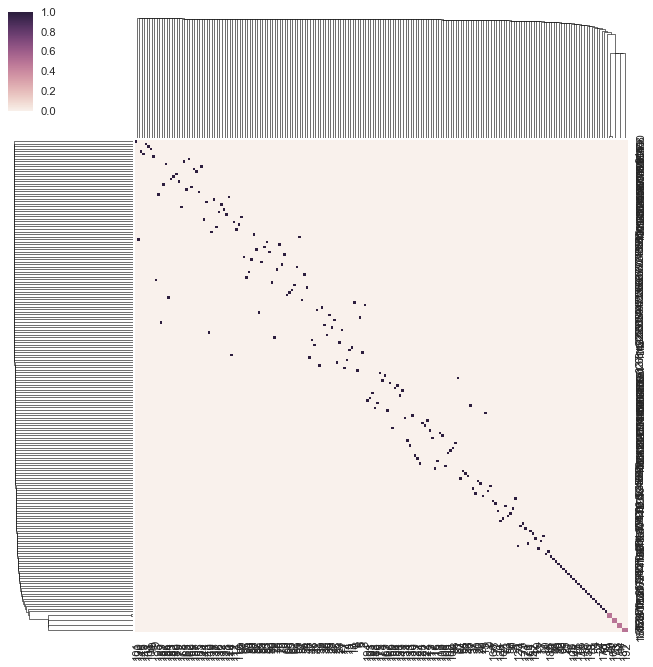

In [65]:
sb.clustermap(pi_prev.T)

In [42]:
B

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [16]:
2.0/L * g_t

matrix([[ -1.58055123e-02,  -5.97305321e-03,  -1.84397810e-03, ...,
          -7.51954878e-05,   3.29180054e-05,   4.02630931e-04],
        [ -6.12056361e-03,  -1.34789892e-02,  -2.58229187e-03, ...,
          -1.11564503e-04,  -2.79872185e-05,   4.06544541e-04],
        [ -5.17254663e-03,  -6.00241740e-03,  -1.21879533e-02, ...,
          -1.10671020e-04,  -4.14057211e-05,   4.53143102e-04],
        ..., 
        [  2.64096239e-04,   4.07435376e-04,  -1.70522420e-04, ...,
          -1.31495731e-02,   8.27899610e-04,  -2.49050993e-03],
        [  2.23808795e-04,   2.70875456e-04,  -1.49820018e-04, ...,
           1.98133195e-03,  -1.37869833e-02,  -1.19544497e-02],
        [  1.83131894e-04,   2.16668306e-04,  -1.90037434e-04, ...,
           1.38022209e-03,  -9.39517482e-03,  -1.43363783e-02]])

In [126]:
### add the original matrix to the result
res[0] = {'pi': K.todense()}

# III. Analysis of the results
We begin by plotting the similarity matrices induced by the method. We can see as the level of regularization increases the emergence of the different clusters. Note as well that taking too large a lambda reverts back to a clustered configuration: this is probably due to the numerical instabilities induced by large values of lambda in the gradient step.

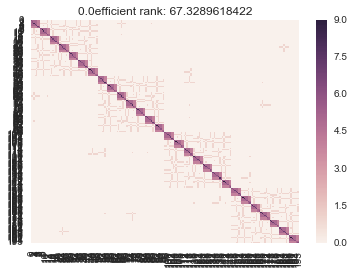

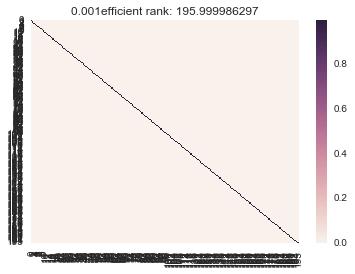

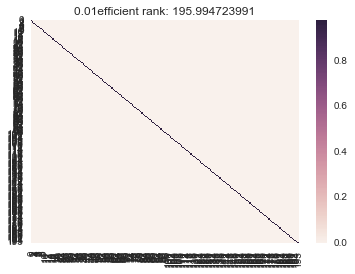

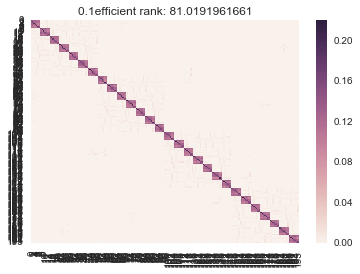

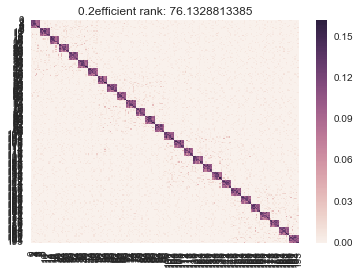

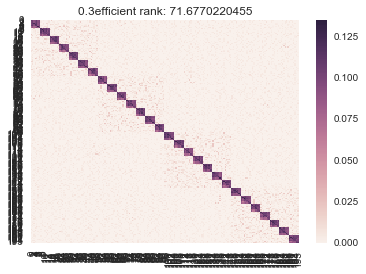

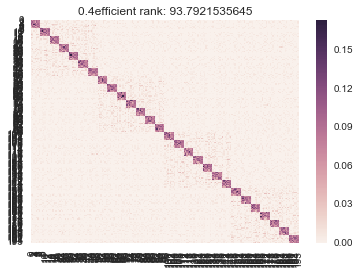

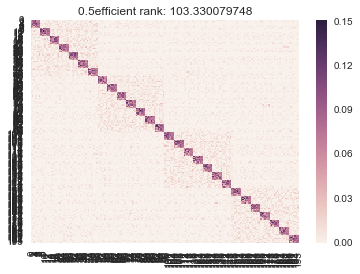

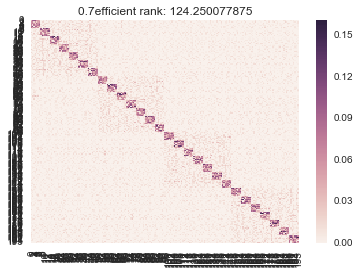

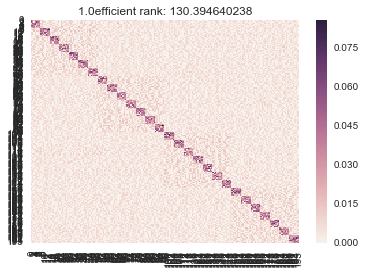

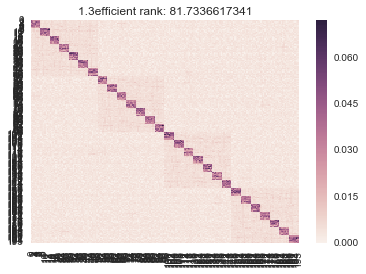

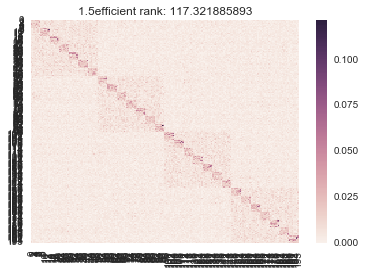

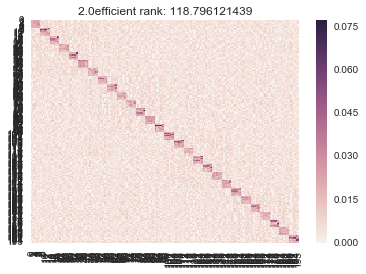

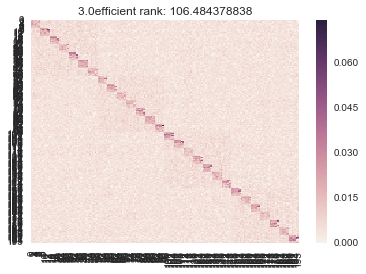

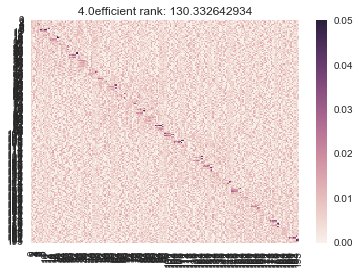

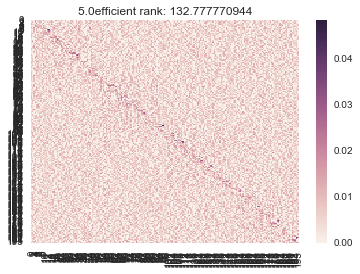

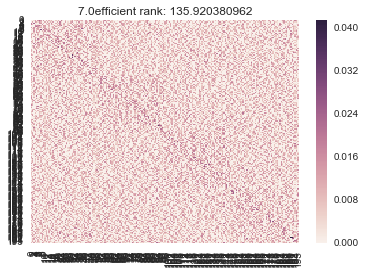

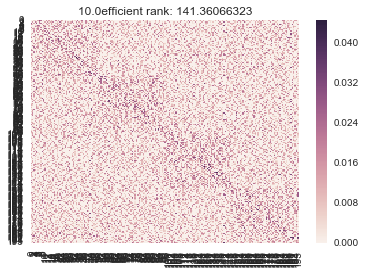

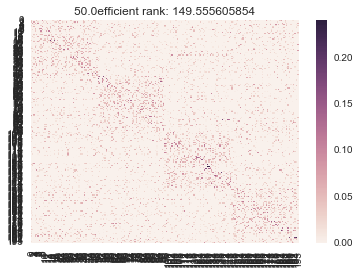

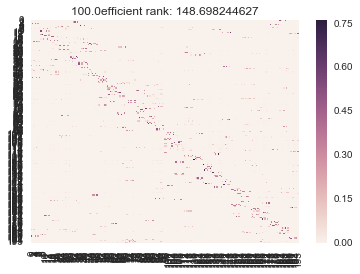

In [127]:
for k in np.sort(res.keys()):
    plt.figure()
    sb.heatmap(res[k]['pi'])
    plt.title(str(k) + 'efficient rank: ' +str(efficient_rank(res[k]['pi'])))

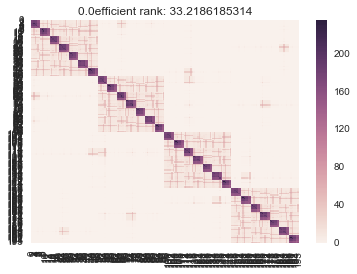

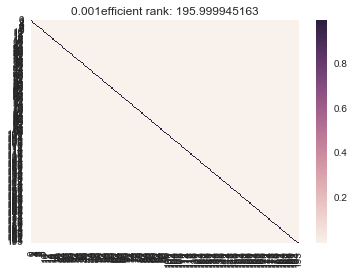

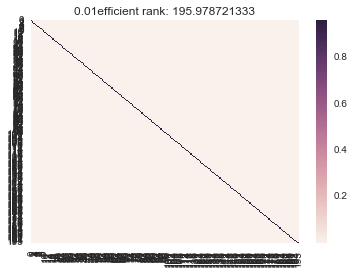

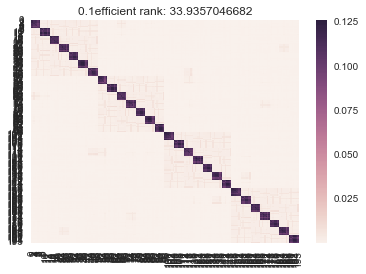

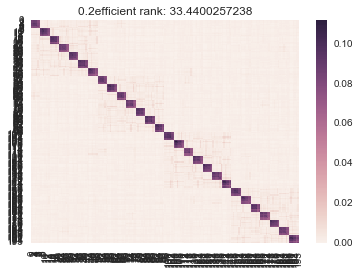

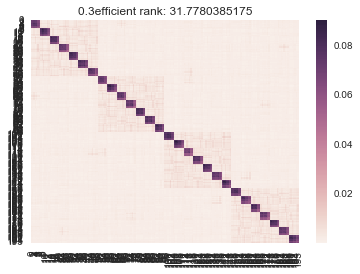

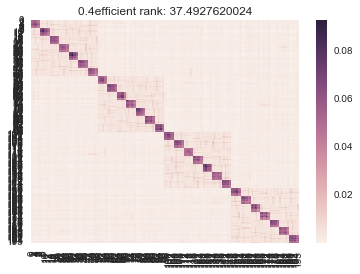

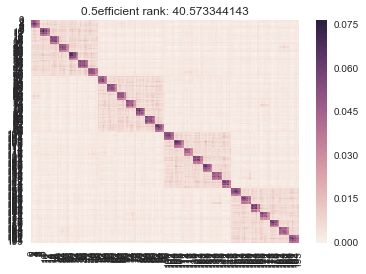

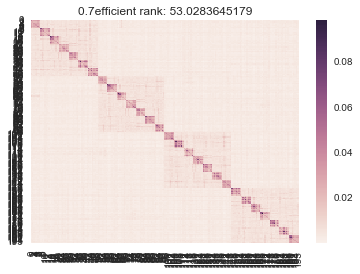

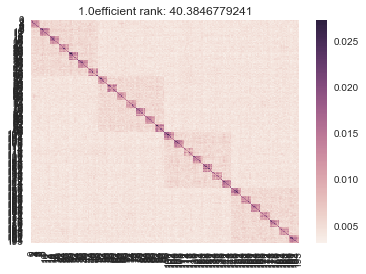

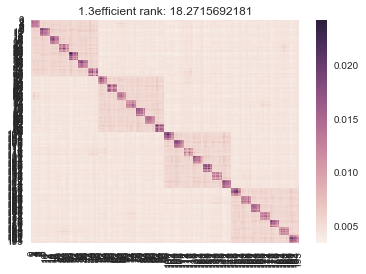

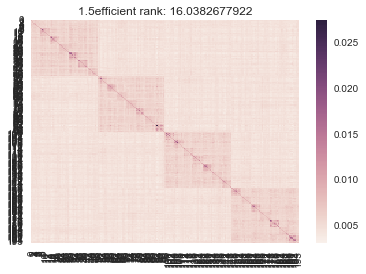

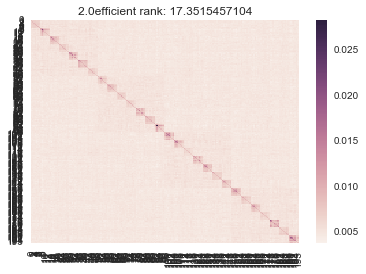

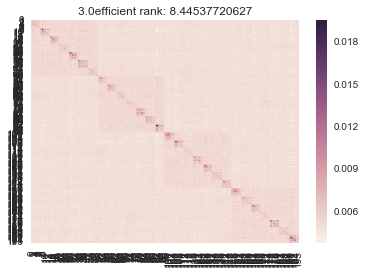

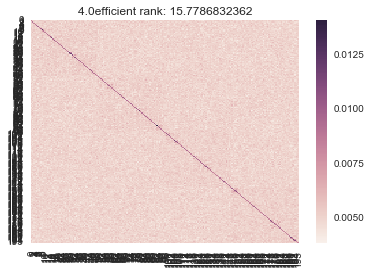

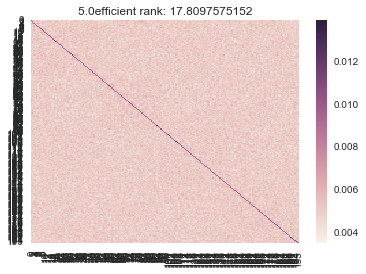

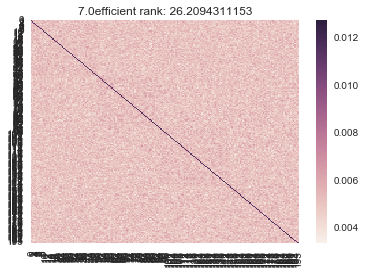

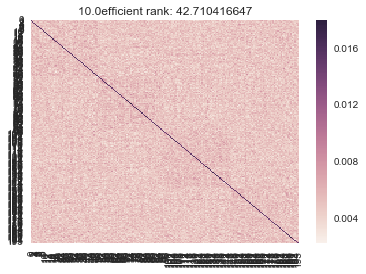

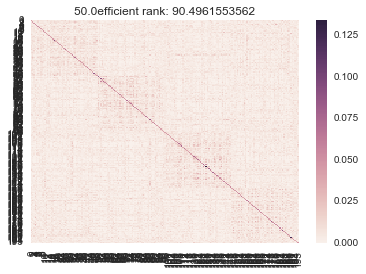

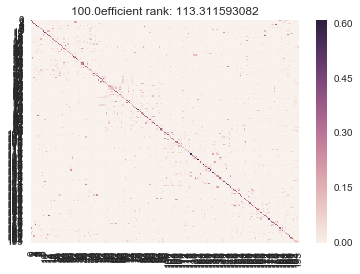

In [ ]:
for k in np.sort(res.keys()):
    plt.figure()
    sb.heatmap(res[k]['pi'].dot(res[k]['pi'].T))
    plt.title(str(k) + 'efficient rank: ' +str(efficient_rank(res[k]['pi'].dot(res[k]['pi'].T))))

In [ ]:
for k in np.sort(res.keys()):
    plt.figure()
    sb.heatmap(res[k]['pi'].T.dot(res[k]['pi']))
    plt.title(str(k) + 'efficient rank: ' +str(efficient_rank(res[k]['pi'].T.dot(res[k]['pi']))))

We now want to assess the utility of this algorithm for extracting hierarchies. We thus run spectral clustering at every level, determining  the number of appropriate clusters with the elbow method.

In [ ]:
from sklearn.cluster import AffinityPropagation, DBSCAN, SpectralClustering

In [ ]:
### Compute the gap statistics for kmeans

### Use modularity maximization for spectral clusterong:
def modularity(A, labels):
    A2 = copy.deepcopy(A)
    np.fill_diagonal(A2,0)
    m = float(A2.sum())
    Q = 1.0
    k = A2.sum(1)
    B = np.zeros(A2.shape)
    for c in np.unique(labels):
        index_c  = np.where(labels == c)
        for cc in index_c[0]:
            B[cc, (labels == c)]+=1
    np.fill_diagonal(B,0)
    #Q += - float(k.T.dot(B.dot(k))/(2.0*m)**2)
    Q = 1.0/(2*m) *np.multiply( A2-k.reshape([-1,1]).dot(k.reshape([1,-1]))/(2*m), B).sum()
    return Q

def elbow_method(X, labels):
    D = 0
    for c in np.unique(labels):
        index_c  = np.where(labels == c)[0]
        mu_c = X[index_c,:].mean(0)
        D += (cdist(X[index_c,:], mu_c) **2).sum()
    return D


def elbow_variance_method(X, labels):
    D = 0
    for c in np.unique(labels):
        index_c  = np.where(labels == c)[0]
        index_c_perp = np.setdiff1d(range(len(labels)), index_c)
        D += (cdist(X[index_c,:], X[index_c_perp,:])**2).sum()

    return D/ (cdist(X, X)**2).sum()

In [ ]:
EE = {}
E = {}
Q = {}
for k in res.keys():
    print(k)
    EE[k], E[k], Q[k] = [], [], []
    for C in range(1,196):
        sc = SpectralClustering(n_clusters=C, affinity='precomputed')
        if k>0:
            train_labels = sc.fit_predict(res[k]['pi'].T.dot(res[k]['pi']))
        else:
            train_labels = sc.fit_predict(res[k]['pi'])
        Q[k].append(modularity(res[k]['pi'].T, train_labels))
        E[k].append(elbow_method(res[k]['pi'].T, train_labels))
        EE[k].append(elbow_variance_method(res[k]['pi'].T, train_labels))

In [ ]:
N_NODES =196
plt.figure()
sb.set_style('white')
cmap = plt.get_cmap('spectral')
colors = [cmap(xx) for xx in np.linspace(0,1,len(EE.keys()))]
it = 0
for k in np.sort(EE.keys()):
    plt.plot(range(1,N_NODES), EE[k], label=k, c = colors[it])
    it +=1
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Elbow (variance)')


In [ ]:
len(np.diff(EE[k])[:50])

In [ ]:
plt.figure()
sb.set_style('white')
cmap = plt.get_cmap('spectral')
colors = [cmap(xx) for xx in np.linspace(0,1,len(EE.keys()))]
it = 0
for k in np.sort(EE.keys()):
    print(k, np.argmax( np.abs(np.diff(EE[k])))+1)
    plt.plot(range(1,81), np.abs(np.diff(EE[k]))[:80], label=k, c = colors[it])
    it +=1
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('diff Elbow (variance)')

In [ ]:
N_NODES =196
plt.figure()
sb.set_style('white')
cmap = plt.get_cmap('spectral')
colors = [cmap(xx) for xx in np.linspace(0,1,len(EE.keys()))]
it = 0
for k in np.sort(E.keys())[1:]:
    plt.plot(range(1,N_NODES), E[k], label=k, c = colors[it])
    it +=1
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Elbow')


In [ ]:
N_NODES =196
plt.figure()
sb.set_style('white')
cmap = plt.get_cmap('spectral')
colors = [cmap(xx) for xx in np.linspace(0,1,len(EE.keys()))]
it = 0
for k in np.sort(Q.keys()):
    plt.plot(range(1,N_NODES), Q[k], label=k, c = colors[it])
    it +=1
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Modularity')


In [ ]:
help(np.diff)

(0.0, array([128,  41,  55, 115,  48]))
(0.001, array([192, 176,  28, 184, 186]))
(0.01, array([ 48, 129,  65,  28, 179]))
(0.10000000000000001, array([151, 154, 172, 136, 117]))
(0.20000000000000001, array([143, 172, 170, 164,  33]))
(0.29999999999999999, array([ 28,  27, 192, 157, 189]))
(0.40000000000000002, array([ 76, 109,  79,  46,  42]))
(0.5, array([174, 156,  88,  91,  67]))
(0.69999999999999996, array([147, 176, 140,  75, 138]))
(1.0, array([152,  36,  22,  60,  54]))
(1.3, array([120, 138, 179, 157,  64]))
(1.5, array([137,  84,  50, 101,  79]))
(2.0, array([132,  40,  65, 108,  11]))
(3.0, array([ 92,  17,  73, 179,   9]))
(4.0, array([ 89, 154,  97,  50,  42]))
(5.0, array([ 80,  95,  30, 186, 160]))
(7.0, array([27, 78, 29, 42, 69]))
(10.0, array([ 98,  29, 179,  12, 169]))
(50.0, array([ 25,  30, 173,  47,  79]))
(100.0, array([ 16, 186, 190, 188,  55]))


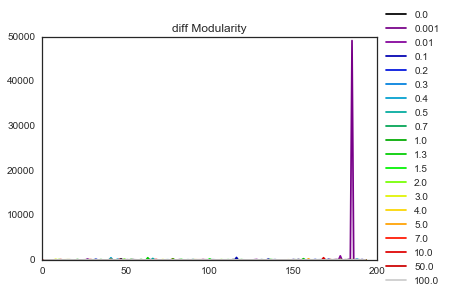

In [78]:
plt.figure()
sb.set_style('white')
cmap = plt.get_cmap('spectral')
colors = [cmap(xx) for xx in np.linspace(0,1,len(EE.keys()))]
it = 0
for k in np.sort(EE.keys()):
    print(k, np.argsort(np.abs((np.diff(Q[k])[:-1]-np.diff(Q[k])[1:])/(np.diff(Q[k])[:-1])))[-5:]+2)#,np.sort(np.abs(np.diff(Q[k])[:-1]/np.diff(Q[k])[1:]))[-5:])
    plt.plot(range(1,N_NODES-2), np.abs((np.diff(Q[k])[:-1]-np.diff(Q[k])[1:])/(np.diff(Q[k])[:-1])), label=k, c = colors[it])
    it +=1
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('diff Modularity')

(0.01, array([  66.00588863,   82.70194334,   98.22517336,  155.02757249,
        901.14678699]))
(0.01, array([ 48, 129,  65,  28, 179]))
(0.10000000000000001, array([  45.80036608,   84.95800128,  105.74847087,  173.38808468,
        550.55350721]))
(0.10000000000000001, array([151, 154, 172, 136, 117]))
(0.20000000000000001, array([  33.48604342,   34.51389525,   39.85735319,   73.97117723,
        147.87201491]))
(0.20000000000000001, array([143, 172, 170, 164,  33]))
(0.29999999999999999, array([  14.78182502,   20.72139555,   40.42911038,   55.15514775,
        167.5026691 ]))
(0.29999999999999999, array([ 28,  27, 192, 157, 189]))
(0.40000000000000002, array([  26.01834498,   37.75857238,   45.05619773,  143.92184313,
        486.89522268]))
(0.40000000000000002, array([ 76, 109,  79,  46,  42]))
(0.5, array([  17.32149333,   20.9351584 ,   28.52097162,   65.78928916,
        321.36618381]))
(0.5, array([174, 156,  88,  91,  67]))
(0.69999999999999996, array([ 10.12607296,  12.2

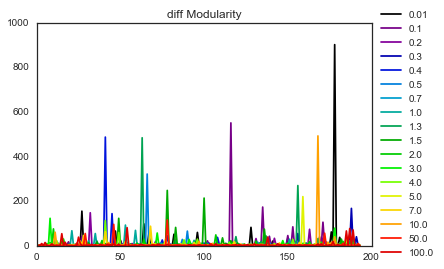

In [80]:
plt.figure()
sb.set_style('white')
cmap = plt.get_cmap('spectral')
colors = [cmap(xx) for xx in np.linspace(0,1,len(EE.keys()))]
it = 0
for k in np.sort(EE.keys())[2:]:
    print(k, np.sort(np.abs((np.diff(Q[k])[:-1]-np.diff(Q[k])[1:])/(np.diff(Q[k])[:-1])))[-5:])
    print(k, np.argsort(np.abs((np.diff(Q[k])[:-1]-np.diff(Q[k])[1:])/(np.diff(Q[k])[:-1])))[-5:]+2)#,np.sort(np.abs(np.diff(Q[k])[:-1]/np.diff(Q[k])[1:]))[-5:])
    plt.plot(range(1,N_NODES-2), np.abs((np.diff(Q[k])[:-1]-np.diff(Q[k])[1:])/(np.diff(Q[k])[:-1])), label=k, c = colors[it])
    it +=1
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('diff Modularity')

In [114]:
from evluation_methods import *
plt.figure()
sb.set_style('white')
cmap = plt.get_cmap('spectral')
colors = [cmap(xx) for xx in np.linspace(0,1,len(EE.keys()))]
results_comp = {}
results= {}
it = 0
U, Sigma, V = np.linalg.svd(K.todense())
X = np.diagflat(np.sqrt(Sigma)).dot(U.T)

for k in [0.01, 0.1,0.5,1.0,1.3, 2.0]:
    for n_c in [4,49]:
        sc = SpectralClustering(n_clusters=n_c, affinity='precomputed')
        sc2 = SpectralClustering(n_clusters=n_c, affinity='precomputed')
        if k>0:
            train_labels = sc.fit_predict(res[k]['pi'].T.dot(res[k]['pi']))
        else:
            train_labels = sc.fit_predict(res[k]['pi']) 
        results[str(k)+'_'+str(n_c)] = [homogeneity_score([l/7 for l in labels], train_labels), 
                        homogeneity_score([(l/7)/4 for l in labels], train_labels),
                        accuracy_score([l/7 for l in labels], train_labels), 
                        accuracy_score([(l/7)/4 for l in labels], train_labels),
                        f1_score([l/7 for l in labels], train_labels, average='micro'), 
                        f1_score([(l/7)/4 for l in labels], train_labels, average='micro'),
                        silhouette_score(res[k]['pi'].T, [l/7 for l in labels]), 
                    silhouette_score(res[k]['pi'].T, [(l/7)/4 for l in labels]),
                       ]
        compare_labels = sc2.fit_predict(K.todense())
        results_comp[str(k)+'_' + str(n_c)] = [homogeneity_score([l/7 for l in labels], compare_labels), 
                    homogeneity_score([(l/7)/4 for l in labels], compare_labels),
                    accuracy_score([l/7 for l in labels], compare_labels), 
                    accuracy_score([(l/7)/4 for l in labels], compare_labels),
                    f1_score([l/7 for l in labels], compare_labels, average='micro'), 
                    f1_score([(l/7)/4 for l in labels], compare_labels, average='micro'),
                    silhouette_score(X.T, [l/7 for l in labels]), 
                    silhouette_score(X.T, [(l/7)/4 for l in labels]),
                   ]



In [115]:
results_pd = pd.DataFrame.from_dict(results, orient='index')
results_pd.sort_index(inplace=True)
results_pd.columns = ['homogeneity level2', 'homogeneity level1',
                           'accuracy level2', 'accuracylevel1',
                           'f1 level2', 'f1 level1', 'silh level2', 'silh level1']


results_comp_pd = pd.DataFrame.from_dict(results_comp, orient='index')
results_comp_pd.sort_index(inplace=True)
results_comp_pd.columns = ['homogeneity level2', 'homogeneity level1',
                           'accuracy level2', 'accuracylevel1',
                           'f1 level2', 'f1 level1','silh level2', 'silh level1']

In [116]:
results_pd

,homogeneity level2,homogeneity level1,accuracy level2,accuracylevel1,f1 level2,f1 level1,silh level2,silh level1
0.01_4,0.416029,0.578961,0.035714,0.142857,0.035714,0.142857,0.002033,0.000516
0.01_49,0.992831,0.987724,0.025510,0.000000,0.025510,0.000000,0.002033,0.000516
0.1_4,0.416029,0.578961,0.035714,0.035714,0.035714,0.035714,0.816181,0.181986
0.1_49,1.000000,1.000000,0.000000,0.035714,0.000000,0.035714,0.816181,0.181986
0.5_4,0.416029,0.578961,0.035714,0.142857,0.035714,0.142857,0.701988,0.155407
0.5_49,0.992937,0.987905,0.005102,0.000000,0.005102,0.000000,0.701988,0.155407
1.0_4,0.416029,0.578961,0.035714,0.071429,0.035714,0.071429,0.234654,0.058003
1.0_49,0.996169,0.993440,0.020408,0.040816,0.020408,0.040816,0.234654,0.058003
1.3_4,0.416029,0.578961,0.035714,0.250000,0.035714,0.250000,0.634826,0.143636
1.3_49,1.000000,1.000000,0.035714,0.035714,0.035714,0.035714,0.634826,0.143636


In [117]:
results_comp_pd

,homogeneity level2,homogeneity level1,accuracy level2,accuracylevel1,f1 level2,f1 level1,silh level2,silh level1
0.01_4,0.416029,0.578961,0.035714,0.250000,0.035714,0.250000,0.415858,0.095307
0.01_49,1.000000,1.000000,0.102041,0.025510,0.102041,0.025510,0.415858,0.095307
0.1_4,0.416029,0.578961,0.035714,0.035714,0.035714,0.035714,0.415858,0.095307
0.1_49,0.994152,0.989987,0.025510,0.061224,0.025510,0.061224,0.415858,0.095307
0.5_4,0.416029,0.578961,0.035714,0.035714,0.035714,0.035714,0.415858,0.095307
0.5_49,1.000000,1.000000,0.035714,0.035714,0.035714,0.035714,0.415858,0.095307
1.0_4,0.416029,0.578961,0.035714,0.178571,0.035714,0.178571,0.415858,0.095307
1.0_49,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.415858,0.095307
1.3_4,0.416029,0.578961,0.035714,0.357143,0.035714,0.357143,0.415858,0.095307
1.3_49,0.994046,0.996365,0.025510,0.071429,0.025510,0.071429,0.415858,0.095307


1.348076923076923

In [89]:
from sklearn.metrics import accuracy_score, homogeneity_score, f1_score, silhouette_score

results_comp = {}
results= {}
for k in np.sort(EE.keys()):
    n_c = np.argsort(np.abs((np.diff(Q[k])[:-1]-np.diff(Q[k])[1:])/(np.diff(Q[k])[:-1])))[-1]+2
    sc = SpectralClustering(n_clusters=n_c, affinity='precomputed')
    sc2 = SpectralClustering(n_clusters=n_c, affinity='precomputed')
    if k>0:
        train_labels = sc.fit_predict(res[k]['pi'].T.dot(res[k]['pi']))
    else:
        train_labels = sc.fit_predict(res[k]['pi']) 
    results[k] = [homogeneity_score([l/7 for l in labels], train_labels), 
                    homogeneity_score([(l/7)/4 for l in labels], train_labels),
                    accuracy_score([l/7 for l in labels], train_labels), 
                    accuracy_score([(l/7)/4 for l in labels], train_labels),
                    f1_score([l/7 for l in labels], train_labels, average='micro'), 
                    f1_score([(l/7)/4 for l in labels], train_labels, average='micro'),
                   ]
    compare_labels = sc2.fit_predict(K.todense())
    results_comp[k] = [homogeneity_score([l/7 for l in labels], compare_labels), 
                homogeneity_score([(l/7)/4 for l in labels], compare_labels),
                accuracy_score([l/7 for l in labels], compare_labels), 
                accuracy_score([(l/7)/4 for l in labels], compare_labels),
                f1_score([l/7 for l in labels], compare_labels, average='micro'), 
                f1_score([(l/7)/4 for l in labels], compare_labels, average='micro'),
               ]



In [101]:
results_pd = pd.DataFrame.from_dict(results, orient='index')
results_pd.sort_index(inplace=True)
results_pd.columns = ['homogeneity level2', 'homogeneity level1',
                           'accuracy level2', 'accuracylevel1',
                           'f1 level2', 'f1 level1']


results_comp_pd = pd.DataFrame.from_dict(results_comp, orient='index')
results_comp_pd.sort_index(inplace=True)
results_comp_pd.columns = ['homogeneity level2', 'homogeneity level1',
                           'accuracy level2', 'accuracylevel1',
                           'f1 level2', 'f1 level1']


In [104]:
results_pd

,homogeneity level2,homogeneity level1,accuracy level2,accuracylevel1,f1 level2,f1 level1
0.000,0.997076,1.000000,0.045918,0.000000,0.045918,0.000000
0.001,0.993632,0.994102,0.005102,0.005102,0.005102,0.005102
0.010,0.996556,0.994102,0.000000,0.005102,0.000000,0.005102
0.100,1.000000,1.000000,0.000000,0.025510,0.000000,0.025510
0.200,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
0.300,1.000000,1.000000,0.005102,0.010204,0.005102,0.010204
0.400,1.000000,1.000000,0.035714,0.107143,0.035714,0.107143
0.500,0.986155,0.984194,0.000000,0.071429,0.000000,0.071429
0.700,0.976915,0.970002,0.005102,0.000000,0.005102,0.000000
1.000,1.000000,1.000000,0.035714,0.000000,0.035714,0.000000


In [103]:
results_comp_pd

,homogeneity level2,homogeneity level1,accuracy level2,accuracylevel1,f1 level2,f1 level1
0.000,0.991246,1.000000,0.061224,0.025510,0.061224,0.025510
0.001,0.990708,0.991359,0.005102,0.015306,0.005102,0.015306
0.010,0.986463,0.984089,0.000000,0.010204,0.000000,0.010204
0.100,0.937760,0.930611,0.005102,0.000000,0.005102,0.000000
0.200,1.000000,1.000000,0.000000,0.061224,0.000000,0.061224
0.300,0.987785,0.991359,0.010204,0.005102,0.010204,0.005102
0.400,0.997076,1.000000,0.035714,0.000000,0.035714,0.000000
0.500,0.982218,0.973185,0.025510,0.000000,0.025510,0.000000
0.700,0.947897,0.935331,0.010204,0.010204,0.010204,0.010204
1.000,0.997877,1.000000,0.035714,0.035714,0.035714,0.035714


In [ ]:
len(np.abs(np.diff(np.diff(E[k]))))

In [ ]:
np.diff(E[k])**2

In [ ]:
k =np.sort(E.keys())[4]
for k in np.sort(E.keys()):
    plt.figure()
    plt.plot(range(3,100),  np.abs(np.diff(np.diff(Q[k]))**2/np.sum(np.diff(np.diff(Q[k]))**2)), label=k)

In [ ]:
plt.figure()
sb.set_style('white')
cmap = plt.get_cmap('spectral')
colors = [cmap(xx) for xx in np.linspace(0,1,len(EE.keys()))]
it = 0
for k in np.sort(E.keys()):
    plt.plot(range(3,100), np.abs(np.diff(np.diff(E[k]))/np.diff(E[k])[:-1]), label=k, c = colors[it])
    it +=1
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))



In [ ]:
# IV. Comparison of the quality of the clustering with alternative methods



In [ ]:
Q = {}
for k in res.keys():
    print(k)
    Q[k] = []
    for C in range(1,100):
        sc = SpectralClustering(n_clusters=C, affinity='precomputed')
        train_labels = sc.fit_predict(res[k]['pi'].T.dot(res[k]['pi']))
        Q[k].append(modularity(res[k]['pi'].T.dot(res[k]['pi']), train_labels))
    #test = aff.fit_predict(res[k]['pi'].dot(res[k]['pi'].T))
#    test = db.fit_predict(X.T)

    #mean[it]+=1.0/20 *len(np.unique(test))

In [ ]:
Q2= {}
for k in res.keys():
    print(k)
    Q2[k] = []
    for C in range(1,100):
        sc = SpectralClustering(n_clusters=C, affinity='precomputed')
        train_labels = sc.fit_predict(res[k]['pi'].T.dot(res[k]['pi']))
        Q2[k].append(modularity(K.todense(), train_labels))
    #test = aff.fit_predict(res[k]['pi'].dot(res[k]['pi'].T))
#    test = db.fit_predict(X.T)

    #mean[it]+=1.0/20 *len(np.unique(test))

In [ ]:
Q[0] = []
for C in range(1,100):
        sc = SpectralClustering(n_clusters=C, affinity='precomputed')
        train_labels = sc.fit_predict(K.todense())
        Q[0].append(modularity(K.todense(), train_labels))


In [ ]:
plt.plot(range(1,100), Q[0], label=0)

In [ ]:
Q[0.01]

In [ ]:
k= 0.1

plt.plot(np.abs(np.diff(Q[k],2)/np.diff(Q[k],1)[:-1]))

In [ ]:
for k in np.sort(Q.keys()):
    print(k, np.argmax(Q[k])+1)

In [ ]:
plt.figure()
sb.set_style('white')
cmap = plt.get_cmap('spectral')
colors = [cmap(xx) for xx in np.linspace(0,1,len(Q.keys()))]
it = 0
for k in np.sort(Q.keys()):
    plt.plot(range(1,100), Q[k], label=k, c = colors[it])
    it +=1
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))


In [ ]:
k=0.01
diff = [None] * (len(Q[k])-1)
for it in range(1,len(Q[k])-1):
    diff[it] = 0.5*np.abs(Q[k][it-1] + Q[k][it+1] -2*Q[k][it])

In [ ]:
def elbo_method(X, labels):
    D = 0
    for c in np.unique(labels):
        index_c  = np.where(labels == c)[0]
        mu_c = X[index_c,:].mean(0)
        #print(index_c)
        for cc in index_c:
             D+=  np.linalg.norm(X[cc,:] -mu_c)**2

        
    return D

In [ ]:
elbo_method(res[0.01]['pi'].T, train_labels)

In [ ]:
mean = []
it = 0
for k in np.sort(res.keys()):
    mean.append(0)
    for t in range(20):
        test = aff.fit_predict(res[k]['pi'].dot(res[k]['pi'].T))
        #test = db.fit_predict(res[k]['pi'].T)
        #STOP
        print(k, len(np.unique(test)))
        mean[it]+=1.0/20 *len(np.unique(test))
    it +=1

In [ ]:
np.linalg.norm( pi_prev_old-pi_prev, 'fro')/np.linalg.norm( pi_prev_old, 'fro')

In [ ]:
evol_efficient_rank

In [ ]:
for k in np.sort(res.keys()):
    plt.figure()
    sb.heatmap(res[k]['pi'].T.dot(res[k]['pi']))
    plt.title(str(k) + 'efficient rank: ' +str(efficient_rank(res[k]['pi'].T.dot(res[k]['pi']))))

In [ ]:
sb.heatmap(Z)

In [ ]:
sb.heatmap(Z.T.dot(Z))

In [ ]:
if True:
    for l in range(100):
        tic = time.time()

        pi_prev_old=pi_prev
        delta_pi=[]
    
        it = 0 
        converged =False
        print("Beginning l=%f"%(lambd0))
        lambd = 2*lambd0/ L
        B = pi_prev
        conv_p[lambd0], conv_q[lambd0], conv_x[lambd0] = {}, {} , {}
        evol_efficient_rank[lambd0] = [efficient_rank(pi_prev)]
        m_tm1, nu_tm1 = np.zeros(B.shape),np.zeros(B.shape)
        eta_t = 1.0
        inc  = 0
        inc_rank = 0
        #pos = np.vectorize(lambda x: return max([0,x]))
        value_taken[lambd0] = [1e18]
        store_pi[lambd0] = [pi_prev]
        while not converged:
            #STOP
            g_t =  (K.todense().dot(B) - K.todense())
            #B=  project_DS2(B - g_t)#+np.abs(B - g_t))
            #tilde_pi = pos(pi_prev - 1.0/n_nodes * np.eyes(n_nodes))
            Z, time_taken, delta_x, delta_p, delta_q, dual, val = hcc_FISTA_denoise(K,
                                                                               B - 2.0/L * g_t,
                                                                               pi_prev,
                                                                               2.0/L*lambd0,
                                                                               alpha=ALPHA, 
                                                                               maxiterFISTA=MAXITERFISTA,
                                                                               eta=eta_t,
                                                                               tol=TOL, 
                                                                               verbose=True,
                                                                               tol_projection=1e-2*TOL,
                                                                               logger=logger)
            
            pi_prev = Z
            if efficient_rank(Z)>evol_efficient_rank[lambd0][-1]:
                pi_prev = pi_prev_old
                value_taken[lambd0].append(value_taken[lambd0][-1])
            else:
                value_taken[lambd0].append(val)
            
            #if it > 2:
            #    if (np.linalg.norm( pi_prev_old-Z, 'fro')/np.linalg.norm( pi_prev_old, 'fro')>0.5
            #       and efficient_rank(Z)>evol_efficient_rank[lambd0][-1]):
            #        pi_prev =pi_prev_old
            store_pi[lambd0].append(pi_prev)

            conv_p[lambd0][it] = delta_p
            conv_q[lambd0][it] = delta_q
            conv_x[lambd0][it] = delta_x
            #value_taken [lambd0] = val
            t_kp1 = 0.5 * (1 + np.sqrt(1 + 4 * t_k**2))
            delta_pi.append(np.linalg.norm( pi_prev_old-pi_prev, 'fro')/np.linalg.norm( pi_prev_old, 'fro'))
            #print delta_pi[-1]
            if delta_pi[-1] < TOL:
                inc += 1
            else:
                inc = 0
            if it > 0:
                if np.abs(efficient_rank(Z)-evol_efficient_rank[lambd0][-1])<0.5:
                    inc_rank += 1
                else:
                    inc_rank = 0
            #converged = (inc >= 5) or (inc_rank > 10 and it > 14) or (it > MAXITERFISTA2)
            converged = (delta_pi[-1] < TOL and inc>2)or (it > MAXITERFISTA2)
            evol_efficient_rank[lambd0] += [efficient_rank(pi_prev)]
            B = pi_prev + (t_k) / t_kp1 * (Z - pi_prev)\
                + (t_k - 1) / t_kp1 * (pi_prev - pi_prev_old)
            pi_prev_old = pi_prev
            t_k = t_kp1
            it +=1
            print('outer loop %i: conv: %f, rank: %f'%(it, delta_pi[-1], evol_efficient_rank[lambd0][-1]))
            print('--------------------------')

        print('--------------------------')
        print('--------------------------')
        print('--------------------------')
        toc = time.time()
        res[lambd0]={'pi':pi_prev, 'convergence': delta_pi, 'time':toc-tic}
        #pickle.dump(res, open(SAVEFILE, 'wb'))
        lambd0 += 0.05

In [ ]:
res[ 1.1000000000000003]['pi']+1.0/n_nodes*I

In [ ]:
lambd0

In [ ]:
lambd0  =100
if True:
        tic = time.time()

        pi_prev_old=pi_prev
        delta_pi=[]
    
        it = 0 
        converged =False
        print("Beginning l=%f"%(lambd0))
        lambd = 2*lambd0/ L
        B = pi_prev
        conv_p[lambd0], conv_q[lambd0], conv_x[lambd0] = {}, {} , {}
        evol_efficient_rank[lambd0] = [efficient_rank(pi_prev)]
        m_tm1, nu_tm1 = np.zeros(B.shape),np.zeros(B.shape)
        eta_t = 1.0
        inc  = 0
        inc_rank = 0
        #pos = np.vectorize(lambda x: return max([0,x]))
        value_taken[lambd0] = [1e18]
        store_pi[lambd0] = [pi_prev]
        while not converged:
            #STOP
            g_t =  (K.todense().dot(B) - K.todense())
            #B=  project_DS2(B - g_t)#+np.abs(B - g_t))
            #tilde_pi = pos(pi_prev - 1.0/n_nodes * np.eyes(n_nodes))
            Z, time_taken, delta_x, delta_p, delta_q, dual, val = hcc_FISTA_denoise(K,
                                                                               B - 2.0/L * g_t,
                                                                               pi_prev,
                                                                               2.0/L*lambd0,
                                                                               alpha=ALPHA, 
                                                                               maxiterFISTA=MAXITERFISTA,
                                                                               eta=eta_t,
                                                                               tol=TOL, 
                                                                               verbose=True,
                                                                               tol_projection=1e-2*TOL,
                                                                               logger=logger)
            
            pi_prev = Z
            if efficient_rank(Z)>evol_efficient_rank[lambd0][-1]:
                pi_prev = pi_prev_old
                value_taken[lambd0].append(value_taken[lambd0][-1])
            else:
                value_taken[lambd0].append(val)
            
            #if it > 2:
            #    if (np.linalg.norm( pi_prev_old-Z, 'fro')/np.linalg.norm( pi_prev_old, 'fro')>0.5
            #       and efficient_rank(Z)>evol_efficient_rank[lambd0][-1]):
            #        pi_prev =pi_prev_old
            store_pi[lambd0].append(pi_prev)

            conv_p[lambd0][it] = delta_p
            conv_q[lambd0][it] = delta_q
            conv_x[lambd0][it] = delta_x
            #value_taken [lambd0] = val
            t_kp1 = 0.5 * (1 + np.sqrt(1 + 4 * t_k**2))
            delta_pi.append(np.linalg.norm( pi_prev_old-pi_prev, 'fro')/np.linalg.norm( pi_prev_old, 'fro'))
            #print delta_pi[-1]
            if delta_pi[-1] < TOL:
                inc += 1
            else:
                inc = 0
            if it > 0:
                if np.abs(efficient_rank(Z)-evol_efficient_rank[lambd0][-1])<0.5:
                    inc_rank += 1
                else:
                    inc_rank = 0
            #converged = (inc >= 5) or (inc_rank > 10 and it > 14) or (it > MAXITERFISTA2)
            converged = (delta_pi[-1] < TOL and inc>2)or (it > MAXITERFISTA2)
            evol_efficient_rank[lambd0] += [efficient_rank(pi_prev)]
            B = pi_prev + (t_k) / t_kp1 * (Z - pi_prev)\
                + (t_k - 1) / t_kp1 * (pi_prev - pi_prev_old)
            pi_prev_old = pi_prev
            t_k = t_kp1
            it +=1
            print('outer loop %i: conv: %f, rank: %f'%(it, delta_pi[-1], evol_efficient_rank[lambd0][-1]))
            print('--------------------------')

        print('--------------------------')
        print('--------------------------')
        print('--------------------------')
        toc = time.time()
        res[lambd0]={'pi':pi_prev, 'convergence': delta_pi, 'time':toc-tic}
        pickle.dump(res, open(SAVEFILE, 'wb'))
        #lambd0 += 0.05

# IV. Comparison with other methods


To compute the quality of the HC results, we rely on different standard clustering and classification metrics:

+ __F-score__: measures the trade-off between precision and recall and relies only on the label of each instance. Since the clusters are balanced by design, we here use the 'macro' F1 score, which is the average one-vs-rest F1 score over the different classes 
+ __RSM matrices__: (Representational Similarity Matrices): the goal here is to measure the correlation between the distances in the tree induced by two different HC. We represent each HC by a square matrix giving similarites between nodes according to the HC: each entry (i,j) is the distance between node i and j induced by th HC, integrated over the whole tree. It is thus 0 if the two nodes are in branches that diverge directly from the root onwards, and 1 - k/tree_depth with k the level of the clsest common ancestor of i and j, and tree_depth the overall tree depth. For non-tree-like hierarchical clustering, this similarity is the Riemann integral of the similarities over the regularization path. This allows us to compare easiy the tree-like and non-tree like HC by taking the (rank-based) Spearman correlation between induced.
+ __Silhouette scores__ : The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. This measures the "discriminative" power of the clustering: are all clusters well separated?
+ __Calinski Harabaz score__ ratio between within-cluster dispersion and the between-cluster dispersion.
+ __Folkes Mallows score__ : similarity between two clusterings
+ __homogeneity, completeness__: A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class. A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.Both scores have positive values between 0.0 and 1.0, larger values being desirable.
+ __The Matthew coefficient__: The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary and multiclass classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. The statistic is also known as the phi coefficient. [source: Wikipedia]


SOURCES:

 + wikipedia
 + sklearn documentation website
 + Incorporating SAT Solvers into Hierarchical Clustering Algorithms - An efficient and Flexible Approach: Sean Gilpin and Ian Davidson, SIGKDD'11 


## a. Spectral Clustering

## b. Average Linkage

## c. Ward

## d. Robust Hierarchical Clustering

## e. Gurobi 